In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('cleaned_immobiliers.csv')

In [3]:
df.head()

,Localisation,Superficie,Chambres,Type de bien,Prix,Salles de bains
0,Nabeul,100.0,2,Appartement,195000.0,1
1,Monastir,460.0,5,Villa,520000.0,2
2,Ben Arous,58.0,1,Appartement,150000.0,1
3,Ben Arous,90.0,1,Appartement,110000.0,1
4,Ben Arous,120.0,5,Maison,350.0,3


In [4]:
df['Superficie'] = pd.to_numeric(df['Superficie'], errors='coerce')
df['Chambres'] = pd.to_numeric(df['Chambres'], errors='coerce')
df['Salles de bains'] = pd.to_numeric(df['Salles de bains'], errors='coerce')
df['Prix'] = pd.to_numeric(df['Prix'], errors='coerce')

# One-hot encoding de la variable 'Type de bien' and 'Localisation'
df_encoded = pd.get_dummies(df, columns=['Type de bien','Localisation'])
df_encoded = df_encoded.astype({col: int for col in df_encoded.select_dtypes(include=['bool']).columns})

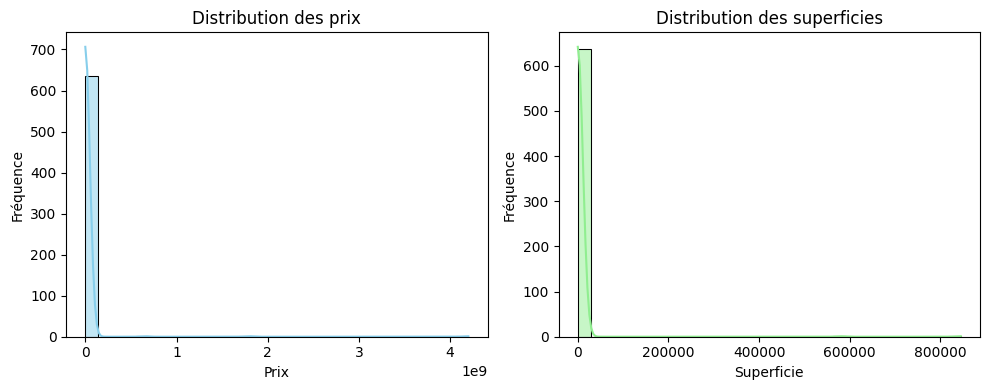

In [13]:
plt.figure(figsize=(10, 4))

# Plot pour les prix
plt.subplot(1, 2, 1)
sns.histplot(df_encoded['Prix'], kde=True, bins=30, color='skyblue')
plt.title('Distribution des prix')
plt.xlabel('Prix')
plt.ylabel('Fréquence')

# Plot pour les superficies
plt.subplot(1, 2, 2)
sns.histplot(df_encoded['Superficie'], kde=True, bins=30, color='lightgreen')
plt.title('Distribution des superficies')
plt.xlabel('Superficie')
plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

On remarque que les distributions des prix et de la superficie sont trop affectées par les valeurs aberrantes, on procède donc à les éliminer.

In [14]:
lower_quantile = df['Prix'].quantile(0.01)
upper_quantile = df['Prix'].quantile(0.99)  

df_filtered = df_encoded[(df_encoded['Prix'] >= lower_quantile) & (df_encoded['Prix'] <= upper_quantile)]

In [15]:
lower_quantile = df['Superficie'].quantile(0.05)
upper_quantile = df['Superficie'].quantile(0.95)

# Filtrer les outliers en fonction des nouveaux quantiles
df_filtered = df_filtered[(df_filtered['Superficie'] >= lower_quantile) & (df_filtered['Superficie'] <= upper_quantile)]
# df_filtered['Superficie'] = df_filtered['Superficie'].clip(lower=df['Superficie'].quantile(0.05), upper=df['Superficie'].quantile(0.95))


In [16]:
# Standardisation des données
cols_to_normalize = ['Superficie', 'Chambres', 'Prix', 'Salles de bains']
scaler = StandardScaler()
df_filtered[cols_to_normalize] = scaler.fit_transform(df_filtered[cols_to_normalize])

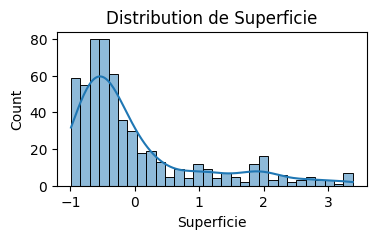

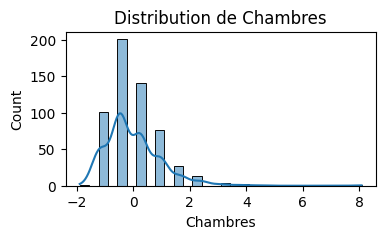

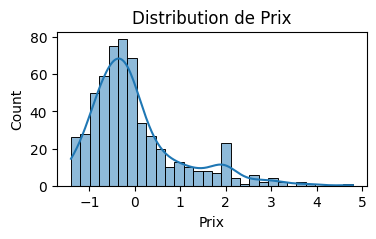

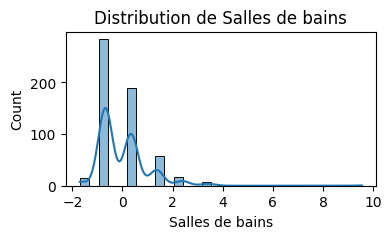

In [17]:
for col in cols_to_normalize:
    plt.figure(figsize=(4, 2))
    sns.histplot(df_filtered[col], kde=True, bins=30)
    plt.title(f'Distribution de {col}')
    plt.show()

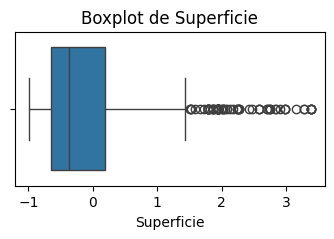

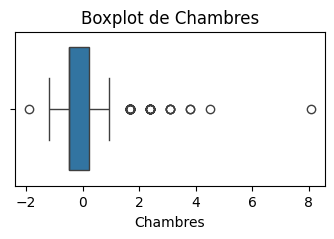

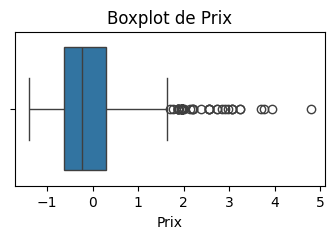

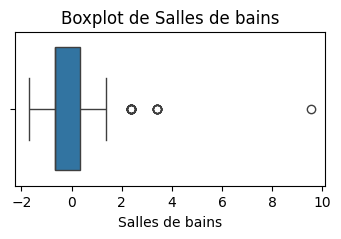

In [24]:
for col in cols_to_normalize:
    plt.figure(figsize=(4, 2))
    sns.boxplot(x=df_filtered[col])
    plt.title(f'Boxplot de {col}')
    plt.show()


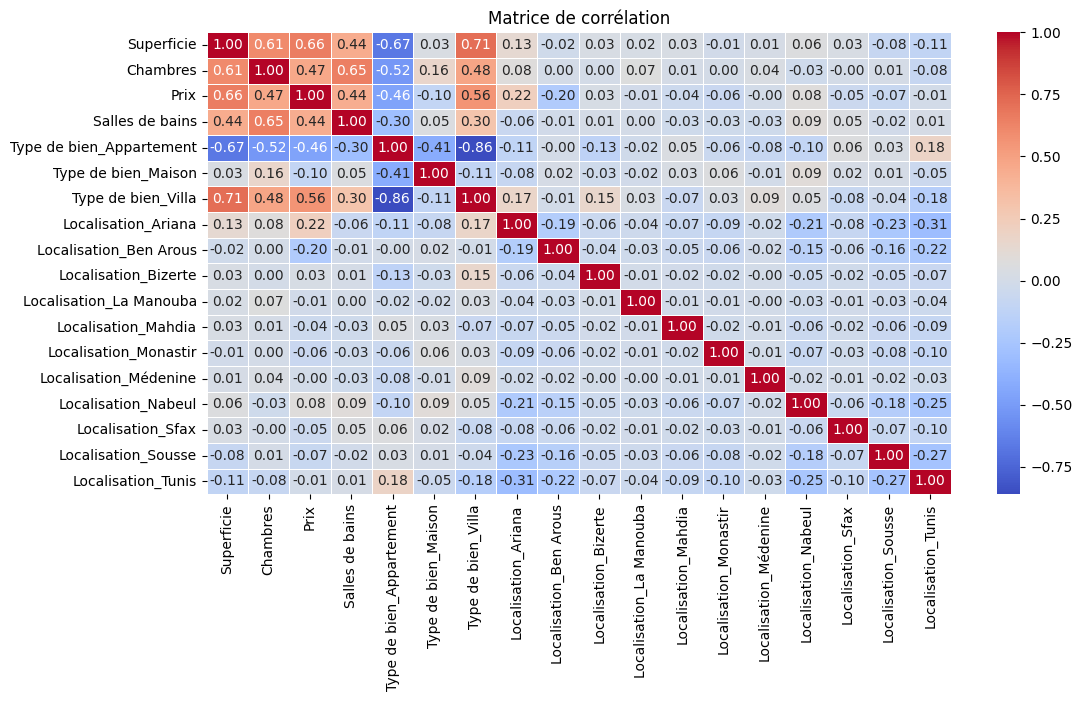

In [32]:
# Calcul de la matrice de corrélation
corr_matrix = df_filtered.corr()

# Visualisation de la matrice de corrélation
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de corrélation')
plt.show()

Superficie: Forte corrélation positive avec le Prix (0.66), ce qui est intuitif : plus la surface est grande, plus le prix augmente.
Corrélation modérée avec le nombre de Chambres (0.61) et de Salles de bains (0.44), ce qui suggère que les grandes surfaces incluent généralement plus de pièces.


Chambres: Corrélation positive avec le Prix (0.47), ce qui indique que le nombre de chambres a un effet sur le prix, bien que moins fort que la surface + forte corrélation avec les Salles de bains (0.44).


Type de bien:
Appartement montre une corrélation négative avec le Prix (-0.55) : les appartements sont généralement moins chers.
Villa a une corrélation positive plus forte avec le prix (0.56), ce qui reflète leur valeur plus élevée.

Localisation:
Certaines localisations, comme Tunis, ont une corrélation positive plus élevée avec le Prix (0.27), ce qui peut indiquer une demande accrue ou des prix plus élevés dans cette région. Ben Arous, en revanche, ne semble pas très corrélé avec le prix (faible coefficient de 0.02).


##### Résumé des insights:
Superficie et Type de bien (spécifiquement Villa vs Appartement) sont les variables les plus influentes pour prédire le prix.
Chambres et Salles de bains apportent également une information intéressante mais avec un impact plus modéré.
Localisation présente des disparités, avec Tunis se démarquant comme un facteur d'importance.

In [27]:
X = df_filtered.drop(['Prix'], axis=1)
y = df_filtered['Prix']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=2)

In [29]:
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Prix   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     44.67
Date:                Tue, 17 Dec 2024   Prob (F-statistic):           4.32e-85
Time:                        17:34:13   Log-Likelihood:                -581.56
No. Observations:                 569   AIC:                             1195.
Df Residuals:                     553   BIC:                             1265.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [30]:
def predict_price_of_house(taille_maison, nb_chambre, nb_salles_de_bain, 
                            type_de_bien_appartement, type_de_bien_maison, 
                            type_de_bien_villa, localisation_ariana,
                            localisation_ben_arous, localisation_bizerte, 
                            localisation_la_manouba, localisation_mahdia, 
                            localisation_monastir, localisation_medenine, 
                            localisation_nabeul, localisation_sfax, 
                            localisation_sousse, localisation_tunis):
    
    # Coefficients from the regression results
    coef_const = -0.1775
    coef_superficie = 0.4311
    coef_chambres = 0.0213
    coef_salles_de_bains = 0.1893
    coef_type_de_bien_appartement = -0.0513
    coef_type_de_bien_maison = -0.5038
    coef_type_de_bien_villa = 0.3776
    coef_localisation_ariana = 0.4399
    coef_localisation_ben_arous = -0.3448
    coef_localisation_bizerte = 0.0229
    coef_localisation_la_manouba = -0.2038
    coef_localisation_mahdia = -0.0866
    coef_localisation_monastir = -0.1308
    coef_localisation_medenine = -0.3389
    coef_localisation_nabeul = 0.2624
    coef_localisation_sfax = -0.1969
    coef_localisation_sousse = 0.1194
    coef_localisation_tunis = 0.2797
    
    # Calculate the predicted price based on the input values
    predicted_price = (coef_const +
                       coef_superficie * taille_maison +
                       coef_chambres * nb_chambre +
                       coef_salles_de_bains * nb_salles_de_bain +
                       coef_type_de_bien_maison * type_de_bien_maison +
                       coef_type_de_bien_appartement * type_de_bien_appartement +
                       coef_type_de_bien_villa * type_de_bien_villa +
                       coef_localisation_ariana * localisation_ariana +
                       coef_localisation_ben_arous * localisation_ben_arous +
                       coef_localisation_bizerte * localisation_bizerte +
                       coef_localisation_la_manouba * localisation_la_manouba +
                       coef_localisation_mahdia * localisation_mahdia +
                       coef_localisation_monastir * localisation_monastir +
                       coef_localisation_medenine * localisation_medenine +
                       coef_localisation_nabeul * localisation_nabeul +
                       coef_localisation_sfax * localisation_sfax +
                       coef_localisation_sousse * localisation_sousse +
                       coef_localisation_tunis * localisation_tunis)
    
    return predicted_price


In [31]:
# Utilisation de la fonction avec l'exemple donné
prix = predict_price_of_house(
    taille_maison=636.0,           # Superficie en m²
    nb_chambre=4,                 # Nombre de chambres
    nb_salles_de_bain=2,          # Nombre de salles de bain
    type_de_bien_maison=False,    # Ce n'est pas une maison (mais une villa)
    type_de_bien_appartement=False,
    type_de_bien_villa=True,     # C'est une villa
    localisation_ben_arous=False, # Localisation Ben Arous (False)
    localisation_bizerte=False,  # Localisation Bizerte (False)
    localisation_la_manouba=False, # Localisation La Manouba (False)
    localisation_mahdia=False,   # Localisation Mahdia (False)
    localisation_monastir=False, # Localisation Monastir (False)
    localisation_medenine=False, # Localisation Médenine (False)
    localisation_nabeul=False,   # Localisation Nabeul (False)
    localisation_sfax=False,     # Localisation Sfax (False)
    localisation_sousse=False,   # Localisation Sousse (False)
    localisation_tunis=False,      # Localisation Tunis  
    localisation_ariana=True,   # Localisation Tunis (True pour Ariana) 
)

print(f"Le prix estimé de la villa à Ariana est : {prix:.2f}")


Le prix estimé de la villa à Ariana est : 275.28
